In [21]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
from sklearn.metrics import accuracy_score
from keras.preprocessing import sequence


In [22]:


#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df




def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)


In [65]:
US500

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2010-01-04,1132.99,1116.56,1133.87,1116.56,0.0,0.0160
2010-01-05,1136.52,1132.66,1136.63,1129.66,0.0,0.0031
2010-01-06,1137.14,1135.71,1139.19,1133.95,0.0,0.0005
2010-01-07,1141.69,1136.27,1142.46,1131.32,0.0,0.0040
2010-01-08,1144.98,1140.52,1145.39,1136.22,0.0,0.0029
...,...,...,...,...,...,...
2018-12-24,2351.10,2400.56,2410.34,2351.10,0.0,-0.0271
2018-12-26,2467.70,2363.12,2467.76,2346.58,0.0,0.0496
2018-12-27,2488.83,2442.50,2489.10,2397.94,0.0,0.0086


In [23]:
KS11 = fdr.DataReader("KS11","2010-01-01","2019-01-01")
KQ11= fdr.DataReader("KQ11","2010-01-01","2019-01-01")
HSI = fdr.DataReader("HSI","2010-01-01","2019-01-01")
IXIC = fdr.DataReader("IXIC","2010-01-01","2019-01-01")

In [16]:
US500=pd.read_csv("C:/Users/이승희/딥러닝 연구/케라스 연구/2020.04.26 정확도 점검/S_P.csv")
US500_=pd.DataFrame(index=US500["Date"])
US500=US500.set_index(US500_.index)
US500=US500.drop(labels=["Date","Adj Close"],axis=1)
US500 = US500.sort_index()
US500=US500[13301:]
list=[]
for n in range(len(US500)-1):
    list.append((US500["Close"][n+1]/US500["Close"][n])-1)
a=pd.DataFrame(list,index=US500.index[1:])
US500=US500.assign(Change=a)

In [39]:
df=KS11
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df.index):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

listofzeros = [0] * 40
CHMF = CMFlow(df, 20)
if len(CHMF)==0:
    CHMF = [0] * df.shape[0]
    df['Chaikin_MF'] = CHMF
else:
    df['Chaikin_MF'] = listofzeros+CHMF
    
    
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df.index)
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull
    
    # ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100

df['ROC'] = ((df['Close'] - df['Close'].shift(12))/(df['Close'].shift(12)))*100
df = df.fillna(0)

techindi2=df
techindi2['VWAP'] = np.cumsum(techindi2['Volume'] * (techindi2['High'] + techindi2['Low'])/2) / np.cumsum(techindi2['Volume'])
techindi2 = techindi2.fillna(0)


techindi2['Momentum'] = techindi2['Close'] - techindi2['Close'].shift(4)
techindi2 = techindi2.fillna(0)
techindi2.tail()
df=techindi2


In [177]:
nparr

,Open,High,Low,Close,Volume,kdj_k,kdj_d,kdj_j,MA_26,MA_52,RSI_14D,Chaikin_MF,psar,ROC,VWAP,Momentum
Date,,,,,,,,,,,,,,,,
2010-05-06,1164.380005,1167.579956,1065.790039,1211.483175,10617809600,40.490865,31.785270,33.345059,1191.651921,1167.652109,33.512057,0.000000,1211.483175,-0.101201,1189.873665,-6.804944
2010-05-07,1127.040039,1135.130005,1094.150024,1199.827724,9472910400,29.277296,30.949279,32.147169,1189.399996,1167.965186,35.214794,0.000000,1199.827724,-0.967481,1184.712493,-17.727032
2010-05-10,1122.270020,1163.849976,1122.270020,1189.104709,6893700000,60.995997,40.964851,36.556010,1188.693458,1169.013071,47.393098,0.000000,1189.104709,-1.807222,1182.731931,-27.731352
2010-05-11,1156.390015,1170.479980,1147.709961,1179.239536,5842550000,58.437760,46.789154,41.672582,1187.476154,1170.029419,46.935659,0.000000,1179.239536,-0.375145,1181.816278,-35.647883
2010-05-12,1155.430054,1172.869995,1155.430054,1065.790039,5225460000,68.748781,54.109030,47.890806,1186.792696,1171.321343,50.054763,0.000000,1065.790039,-10.010707,1181.224698,-145.693136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-30,2286.010010,2286.010010,2268.040039,2265.952674,3591270000,57.017346,76.490969,80.474021,2270.010357,2244.569021,59.825966,3.073469,2265.952674,1.132347,1646.820879,13.803656
2017-01-31,2274.020020,2279.090088,2267.209961,2300.989990,4087450000,52.674630,68.552189,74.513105,2270.536903,2246.774217,61.917607,3.530757,2300.989990,2.620044,1647.216957,46.892120
2017-02-01,2285.590088,2289.139893,2272.439941,2300.314389,3916610000,54.129342,63.744573,69.128839,2271.251906,2248.681143,59.307445,4.914907,2300.314389,2.517021,1647.600637,42.580345


In [24]:
import time
start = time.time()
Xtrain_size=0
예측dic={}
수익률dic={}
END=0
초기돈=10000
d=1
dd=20
BATCH = 20
count = 0
pred_dic={}
투자결과=[]

총df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])
세트df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])


  
for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["KS11","KQ11","IXIC","HSI","US500"]):

    df = 인덱스
    df=get_stochastic(df)
    df=get_MA(df)
    df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
    df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
    def CMFlow(df, tf):
        CHMF = []
        MFMs = []
        MFVs = []
        x = tf

        while x < len(df.index):
            PeriodVolume = 0
            volRange = df['Volume'][x-tf:x]
            for eachVol in volRange:
                PeriodVolume += eachVol

            MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
            MFV = MFM*PeriodVolume

            MFMs.append(MFM)
            MFVs.append(MFV)
            x+=1

        y = tf
        while y < len(MFVs):
            PeriodVolume = 0
            volRange = df['Volume'][x-tf:x]
            for eachVol in volRange:
                PeriodVolume += eachVol
            consider = MFVs[y-tf:y]
            tfsMFV = 0

            for eachMFV in consider:
                tfsMFV += eachMFV

            tfsCMF = tfsMFV/PeriodVolume
            CHMF.append(tfsCMF)
            y+=1
        return CHMF

    listofzeros = [0] * 40
    CHMF = CMFlow(df, 20)
    if len(CHMF)==0:
        CHMF = [0] * df.shape[0]
        df['Chaikin_MF'] = CHMF
    else:
        df['Chaikin_MF'] = listofzeros+CHMF


    def psar(df, iaf = 0.02, maxaf = 0.2):
        length = len(df)
        dates = (df.index)
        high = (df['High'])
        low = (df['Low'])
        close = (df['Close'])
        psar = df['Close'][0:len(df['Close'])]
        psarbull = [None] * length
        psarbear = [None] * length
        bull = True
        af = iaf
        ep = df['Low'][0]
        hp = df['High'][0]
        lp = df['Low'][0]
        for i in range(2,length):
            if bull:
                psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
            else:
                psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
            reverse = False
            if bull:
                if df['Low'][i] < psar[i]:
                    bull = False
                    reverse = True
                    psar[i] = hp
                    lp = df['Low'][i]
                    af = iaf
            else:
                if df['High'][i] > psar[i]:
                    bull = True
                    reverse = True
                    psar[i] = lp
                    hp = df['High'][i]
                    af = iaf
            if not reverse:
                if bull:
                    if df['High'][i] > hp:
                        hp = df['High'][i]
                        af = min(af + iaf, maxaf)
                    if df['Low'][i - 1] < psar[i]:
                        psar[i] = df['Low'][i - 1]
                    if df['Low'][i - 2] < psar[i]:
                        psar[i] = df['Low'][i - 2]
                else:
                    if df['Low'][i] < lp:
                        lp = df['Low'][i]
                        af = min(af + iaf, maxaf)
                    if df['High'][i - 1] > psar[i]:
                        psar[i] = df['High'][i - 1]
                    if df['High'][i - 2] > psar[i]:
                        psar[i] = df['High'][i - 2]
            if bull:
                psarbull[i] = psar[i]
            else:
                psarbear[i] = psar[i]
        #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
        #return psar, psarbear, psarbull
        df['psar'] = psar
        #df['psarbear'] = psarbear
        #df['psarbull'] = psarbull

        # ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100
    psar(df)
    df['ROC'] = ((df['Close'] - df['Close'].shift(12))/(df['Close'].shift(12)))*100
    df = df.dropna()

    techindi2=df
    techindi2['VWAP'] = np.cumsum(techindi2['Volume'] * (techindi2['High'] + techindi2['Low'])/2) / np.cumsum(techindi2['Volume'])
    techindi2 = techindi2.fillna(0)


    techindi2['Momentum'] = techindi2['Close'] - techindi2['Close'].shift(4)
    techindi2 = techindi2.fillna(0)
    techindi2.tail()
    df=techindi2

    
    
    
    
    
    df = df.drop(labels = ['Momentum_1D'], axis=1)
    df=df.dropna()
    df=df[0:-(len(df)%BATCH)]
    df_test=df
    MA_26=df["Close"].rolling(21).mean()
    y_before=MA_26.dropna()
    
    dfA=df[20:] #값과 값 -> [:] 이평선 -> [20:]  <- [20: 0 XXXX]
    df_test3=dfA
    y=np.where(np.array(dfA["Close"].shift(-1).dropna())>np.array(y_before.shift(-1).dropna()),1,0) #값과 이평선 ( 1일 차 )
    #y=np.where(dfA["Change"].shift(-1).dropna()>0,1,0) #값과 값 ( 1일 차 )
    #y=np.where(np.array(dfA["Close"].shift(-20).dropna())>np.array(y_before.shift(-20).dropna()),1,0) #값과 이평선( 20일 차 )
    #y=np.where(dfA["Change"].shift(-20).dropna()>0,1,0) #값과 값 ( 20일 차 )
    
    df = dfA[:-1] # 1일차일시 [:-1] 20일차일시 [:-20]
    df_test2=df
    nparr=df
    scaler = MinMaxScaler(feature_range=(0, 1))
    df2=pd.DataFrame(columns=["Close","Open",'High','Low','Change','Volume',"kdj_k","kdj_d","kdj_j","MA_26","MA_52","RSI_14D"])

    df2["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))[:,0]
    df2["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))[:,0]
    df2["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))[:,0]
    df2["Volume"]=scaler.fit_transform(nparr["Volume"].values.reshape(-1,1))[:,0]
    df2["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))[:,0]
    df2["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))[:,0]
    df2["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))[:,0]
    df2["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))[:,0]
    df2["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))[:,0]
    df2["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))[:,0]
    df2["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))[:,0]
    df2["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))[:,0]
    df2["VWAP"]=scaler.fit_transform(nparr["VWAP"].values.reshape(-1,1))[:,0]
    df2["Momentum"]=scaler.fit_transform(nparr["Momentum"].values.reshape(-1,1))[:,0]
    df2["ROC"]=scaler.fit_transform(nparr["ROC"].values.reshape(-1,1))[:,0]
    df2["psar"]=scaler.fit_transform(nparr["psar"].values.reshape(-1,1))[:,0]
    df2["Chaikin_MF"]=scaler.fit_transform(nparr["Chaikin_MF"].values.reshape(-1,1))[:,0]

    X=df2.values

    setlen=int(len(X)/20*0.7)*20

    X_train=X[:setlen]
    X_test=X[setlen:]
    y_train=y[:setlen]
    y_test=y[setlen:]

    X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(36, input_shape=(1, 17),return_sequences=True))
    model.add(LSTM(36, input_shape=(1, 17)))
    
    for i in range(2):
        model.add(Dense(18,activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
    model.fit(X_train, y_train, epochs=100, batch_size=16,validation_split=0.1,verbose=0)
    pred=np.where(model.predict(X_test)>0.5,1,0)
    
    print(인덱스명, "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))
    예측dic[인덱스명]=pred
    수익률dic[인덱스명]=dfA["Close"][setlen:]

    #예측머신 끝 --------predict -> 12근방 나옴 ---------------------


        
        
버튼=1
date=0

while 버튼==1:#예측머신돌리기
    day= str(d+(20*date)) +"~" + str(dd+(20*date)) + "일 차"
    date=date+1
    print(day,"---------------------------------")

    세트df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])
       
    
    for x,y in zip(예측dic.keys(),예측dic.values()):
        
           #종료 조건
        if(len(수익률dic[x])==BATCH+20):
            버튼=0
            print("종료, 리밸런싱 수 : " , count)
            print(pred_dic)
            break
            
        
        pred=y[BATCH-20:BATCH]
        pred_sum=sum(pred)
        if count==0:
            pred_dic[x]=pred_sum
        else:
            pred_dic[x]=np.append(pred_dic[x],pred_sum)
        예측 = (pred_sum)/20
        실제수익률 = ((수익률dic[x][BATCH+20])/(수익률dic[x][BATCH]))-1
        턴df=pd.DataFrame(data={"영업일":[day],"인덱스":[x],"상승예측확률":[예측],"실제수익률":[실제수익률] }, columns=["영업일","인덱스","상승예측확률","실제수익률"])
        세트df=pd.concat([세트df,턴df])    

           
    if 버튼==0:
        break
        
        
        
    earn_list=[]             
    for x,y in zip(세트df["상승예측확률"],세트df["실제수익률"]):
        
        if x>=0.6:
            earn_list.append(y)
    
    #하나도 상승 아닐때 규제 줄이기
    if len(earn_list)==0:
        for x,y in zip(세트df["상승예측확률"],세트df["실제수익률"]):
        
            if x>=0.4:
                earn_list.append(y)
        
    earn_list2=[]
    if len(earn_list)!=0:
        초기돈=초기돈/(len(earn_list))
        for y in earn_list:
            earn_list2.append(초기돈+(초기돈*y))
        초기돈=sum(earn_list2)    
    else:
        earn_list2.append(초기돈)
    

    총df=pd.concat([총df,세트df])
    BATCH=BATCH+20

    print("분산 투자 : ",earn_list2)
    print("투자 결과 : ",초기돈)
    count=count+1
    print("\n★")
    print(세트df)
    print("★\n")
    
   
            #MONEY = 투잣돈 * A의 20일후 change + 투잣돈 * B의 20일후 change #"20일차MONEY"출력


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KS11 정확도 :  0.8779342723004695
KQ11 정확도 :  0.676056338028169
IXIC 정확도 :  0.7587253414264037
HSI 정확도 :  0.8450704225352113


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [21]:

for x,y in zip(pred_dic.keys(),pred_dic.values()):
    print(x ,"평균 : " , sum(y)/25)
    sum_ =0
    for z in y:
        sum_ = sum_ + (((sum(y)/25)-z)**2)
    print("분산 : " ,sum_/25)

KS11 평균 :  3.0
분산 :  25.08
KQ11 평균 :  16.48
분산 :  60.713216
IXIC 평균 :  2.36
분산 :  18.613183999999993
HSI 평균 :  5.52
분산 :  33.46841600000001
US500 평균 :  20.0
분산 :  0.0


TypeError: 'list' object is not callable

In [36]:
model.predict(X_test)


array([[0.64919096],
       [0.6283208 ],
       [0.62869966],
       [0.5587075 ],
       [0.52913904],
       [0.46719518],
       [0.57031137],
       [0.55520236],
       [0.565216  ],
       [0.6474572 ],
       [0.5013679 ],
       [0.5691583 ],
       [0.47936416],
       [0.611876  ],
       [0.646947  ],
       [0.65888613],
       [0.6231308 ],
       [0.6622871 ],
       [0.65494335],
       [0.66708934],
       [0.6362884 ],
       [0.663793  ],
       [0.60741615],
       [0.64821434],
       [0.58505416],
       [0.5229235 ],
       [0.4897407 ],
       [0.5913419 ],
       [0.56106794],
       [0.8062049 ],
       [0.8750479 ],
       [0.8731902 ],
       [0.8739071 ],
       [0.67576975],
       [0.6505736 ],
       [0.6362762 ],
       [0.8395217 ],
       [0.7195856 ],
       [0.8377894 ],
       [0.8621841 ],
       [0.8586443 ],
       [0.7878351 ],
       [0.73842335],
       [0.57372946],
       [0.6032931 ],
       [0.56565225],
       [0.59905505],
       [0.574

In [7]:
%matplotlib inline

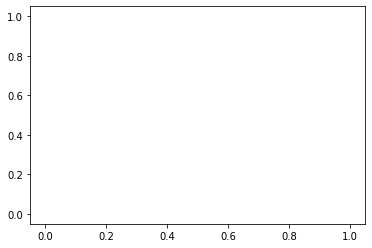

In [9]:
plt.plot(US500["Close"][30000:])


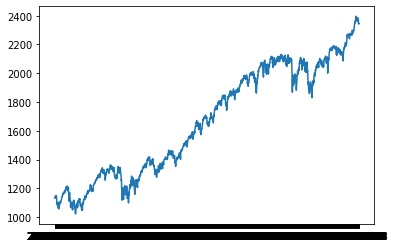

In [19]:
plt.plot(US500["Close"])


In [17]:
US500.shape

(1819, 6)

In [20]:
US500=fdr.DataReader("US500")